# 🧠 Hyper-Personalized Landing Page Generator
### AIgnition 2.0 Hackathon

#### Data Understanding & Preprocessing

- Loaded user activity logs & transaction data.
- Merged them on transaction_id to combine browsing and purchase info.
- Converted timestamps to datetime for session logic.
- Reconstructed sessions grouped by user_pseudo_id for complete user journeys.
- Added a basic engagement metric to count sessions.
- Output is merged_sessions.csv for the next stage.


In [4]:
# Import libraries
import pandas as pd
import numpy as np

# Load datasets
activity_df = pd.read_csv("dataset1_final.csv")
transaction_df = pd.read_csv("dataset2_final.csv")

# Preview data and columns
print("Columns in activity_df:", activity_df.columns.tolist())
print("Columns in transaction_df:", transaction_df.columns.tolist())
print(activity_df.head())
print(transaction_df.head())

# Check data types and sample values of the merge keys
print("Data type of transaction_id in activity_df:", activity_df['transaction_id'].dtype)
print("Data type of Transaction_ID in transaction_df:", transaction_df['Transaction_ID'].dtype)
print("Sample values of eventTimestamp:", activity_df['eventTimestamp'].head().tolist())

# Convert transaction_id columns to the same type (string)
activity_df['transaction_id'] = activity_df['transaction_id'].astype(str)
transaction_df['Transaction_ID'] = transaction_df['Transaction_ID'].astype(str)

# Join datasets on transaction_id to link browsing behavior with purchases
merged_df = pd.merge(activity_df, transaction_df,
                     left_on='transaction_id',
                     right_on='Transaction_ID',
                     how='left')

# Fill missing transaction fields for non-purchase events
merged_df.fillna({'ItemID': 'None',
                  'ItemName': 'None',
                  'ItemBrand': 'None',
                  'ItemCategory': 'None',
                  'Item_purchase_quantity': 0,
                  'Item_revenue': 0}, inplace=True)

# Convert eventTimestamp (handle time string format like '21:57.9')
try:
    # Attempt to parse as a time string (e.g., HH:MM:SS.s)
    merged_df['eventTimestamp'] = pd.to_datetime(merged_df['eventTimestamp'], format='%H:%M:%S.%f', errors='coerce').dt.time
except ValueError:
    # If format varies, try flexible parsing
    merged_df['eventTimestamp'] = pd.to_datetime(merged_df['eventTimestamp'], errors='coerce')

# Convert eventDate
merged_df['eventDate'] = pd.to_datetime(merged_df['eventDate'], errors='coerce')

# Combine eventDate and eventTimestamp into a full datetime for sorting
merged_df['full_timestamp'] = pd.to_datetime(
    merged_df['eventDate'].astype(str) + ' ' + merged_df['eventTimestamp'].astype(str),
    errors='coerce'
)

# Check columns in merged_df
print("Columns in merged_df:", merged_df.columns.tolist())

# Create session_start if it doesn't exist
if 'session_start' not in merged_df.columns:
    print("session_start column not found. Creating session_start based on first event per user session.")
    # Assume a new session starts with the first event per user (or use a time gap, e.g., 30 minutes)
    merged_df = merged_df.sort_values(['user_pseudo_id', 'full_timestamp'])
    merged_df['session_start'] = merged_df.groupby('user_pseudo_id')['full_timestamp'].transform('min') == merged_df['full_timestamp']
    merged_df['session_start'] = merged_df['session_start'].astype(int)  # 1 for session start, 0 otherwise

# Reconstruct user sessions
sessions = merged_df.groupby('user_pseudo_id').apply(
    lambda x: x.sort_values('full_timestamp')
).reset_index(drop=True)

# Basic engagement metric: number of sessions per user
sessions['session_number'] = sessions.groupby('user_pseudo_id')['session_start'].cumsum()

# Save cleaned dataset
sessions.to_csv('merged_sessions.csv', index=False)

print("Data Understanding & Preprocessing complete.")

Columns in activity_df: ['user_pseudo_id', 'event_name', 'category', 'city', 'region', 'country', 'source', 'medium', 'purchase_revenue', 'total_item_quantity', 'transaction_id', 'eventDate', 'eventTimestamp', 'gender', 'Age', 'page_type', 'income_group', 'page_path']
Columns in transaction_df: ['Date', 'Transaction_ID', 'Item_purchase_quantity', 'Item_revenue', 'ItemName', 'ItemBrand', 'ItemCategory', 'ItemID']
   user_pseudo_id     event_name category      city    region        country  \
0    1.789251e+09  session_start   mobile  Poquoson  Virginia  United States   
1    1.789251e+09      page_view   mobile  Poquoson  Virginia  United States   
2    1.788384e+09  session_start   mobile  Carthage  New York  United States   
3    1.788384e+09      page_view   mobile  Carthage  New York  United States   
4    1.198796e+09      page_view   mobile   Phoenix   Arizona  United States   

     source      medium  purchase_revenue  total_item_quantity transaction_id  \
0  Facebook  PaidSocia

/var/folders/n7/5q8_15jd4sd7c95_4v7gct4m0000gn/T/ipykernel_75129/149479149.py:47: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_df['eventDate'] = pd.to_datetime(merged_df['eventDate'], errors='coerce')
/var/folders/n7/5q8_15jd4sd7c95_4v7gct4m0000gn/T/ipykernel_75129/149479149.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sessions = merged_df.groupby('user_pseudo_id').apply(


#### User Segmentation

- Aggregated user-level features: engagement, top event, top source, demographic averages.
- Encoded categorical variables.
- Applied KMeans clustering to create behavioral segments: e.g., high spenders, cart abandoners, repeat visitors.
- Saved segments for personalization and fallback logic.

   user_pseudo_id  session_number  event_name  category  city  region  \
0    8.073962e+05               0           1         1   223      22   
1    7.086535e+06               0           1         0    58      57   
2    1.965358e+07               0           0         0   203       7   
3    2.014393e+07               0           0         1    93       9   
4    2.147340e+07               0           0         1    43      53   

   country  source  medium  gender     Age  income_group  purchase_revenue  \
0       25      11       7       1  54.500             0               0.0   
1       25       0       0       1  49.500             0               0.0   
2       25       0       0       1  49.500             0               0.0   
3       25      11       7       1  39.875             4               0.0   
4       25       0       0       1  49.500             0               0.0   

   segment  
0        3  
1        0  
2        3  
3        1  
4        0  


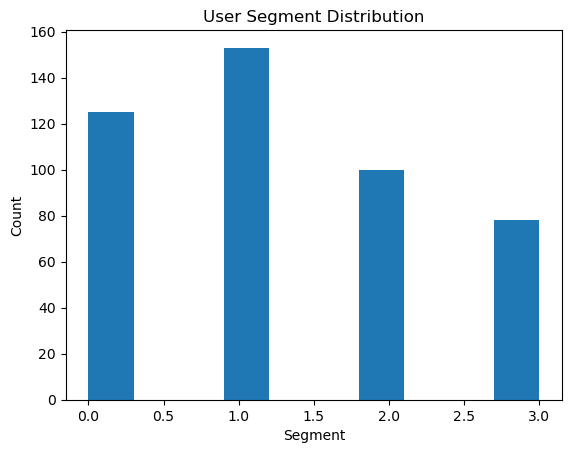

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re

# --- Safe functions ---

def safe_mode(x):
    x = x.dropna()
    if len(x) == 0:
        return 'Unknown'
    else:
        return x.value_counts().idxmax()

def parse_age_value(value):
    """
    Converts an age value to a float.
    Handles numeric, range-like '45-54', or non-numeric strings.
    """
    if pd.isna(value):
        return np.nan
    
    value = str(value).strip()
    
    # If it's a simple number
    if re.match(r'^\d+$', value):
        return float(value)
    
    # If it's a range like '45-54'
    match = re.match(r'(\d+)-(\d+)', value)
    if match:
        low, high = match.groups()
        return (float(low) + float(high)) / 2
    
    # If it's unparseable, return NaN
    return np.nan

def safe_mean(x):
    parsed = x.apply(parse_age_value)
    if len(parsed.dropna()) == 0:
        return np.nan
    return parsed.mean()

# --- Aggregation ---

user_features = sessions.groupby('user_pseudo_id').agg({
    'session_number': 'max',
    'event_name': safe_mode,
    'category': safe_mode,
    'city': safe_mode,
    'region': safe_mode,
    'country': safe_mode,
    'source': safe_mode,
    'medium': safe_mode,
    'gender': safe_mode,
    'Age': safe_mean,
    'income_group': safe_mode,
    'purchase_revenue': 'sum'
}).reset_index()

# --- Encode categorical ---

le = LabelEncoder()
for col in ['event_name', 'category', 'city', 'region', 'country',
            'source', 'medium', 'gender', 'income_group']:
    user_features[col] = le.fit_transform(user_features[col].astype(str))

# Fill missing ages with mean
user_features['Age'] = user_features['Age'].fillna(user_features['Age'].mean())

# --- Clustering ---

kmeans = KMeans(n_clusters=4, random_state=42)
user_features['segment'] = kmeans.fit_predict(user_features.drop(['user_pseudo_id'], axis=1))

print(user_features.head())

# Save segments
user_features.to_csv('user_segments.csv', index=False)

# --- Visualize ---
plt.hist(user_features['segment'])
plt.title('User Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.show()


#### Cold Start Strategy Design

- Designed fallback logic for cold start:
  - By region, recommend the top product category in that region.
  - If region not available, use the overall most popular category.
- Simple KNN-style similarity could be extended with actual embeddings or demographic matching for more advanced logic.

In [12]:
# Cold Start Fallback Examples
# 1. By region, device, and source — average top categories
fallback_trends = sessions.groupby(['region', 'category']).agg({
    'purchase_revenue': 'sum'
}).reset_index()

# Get top category per region
fallback_top_categories = fallback_trends.sort_values(['region', 'purchase_revenue'], ascending=[True, False]) \
                                         .groupby('region').first().reset_index()

# Save fallback table
fallback_top_categories.to_csv('fallback_top_categories.csv', index=False)

print(fallback_top_categories.head())

# 2. KNN-like profile similarity fallback
# Example: user with similar demographics and source
# For demonstration, use segments for similarity
# Define simple rule-based function

def recommend_for_new_user(user_region, user_device, user_source):
    top_category = fallback_top_categories[fallback_top_categories['region'] == user_region]['category']
    if len(top_category) > 0:
        return top_category.iloc[0]
    else:
        # If no region match, use global top category
        return fallback_top_categories['category'].value_counts().idxmax()

# Example test
print(recommend_for_new_user('California', 'mobile', 'Organic'))


            region category  purchase_revenue
0          Alberta  desktop               0.0
1            Apure  desktop               0.0
2          Arizona  desktop               0.0
3         Arkansas   mobile               0.0
4  Baja California  desktop               0.0
desktop


#### Personalization Logic Development

- Personalized landing page blocks: Hero Banner, Product Carousel, and CTA Module.
- For known users: use cluster segment to decide the page content.
- For new users: use fallback logic to pick region-based trending categories.
- This modular structure can be mapped to a frontend.

In [14]:
# Updated personalization function with index check
def generate_landing_page(user_id=None, user_region=None):
    if user_id:
        user_row = user_features[user_features['user_pseudo_id'] == user_id]
        
        if not user_row.empty:
            segment = user_row['segment'].iloc[0]
            
            # Rule-based mapping: define banners & modules per segment
            if segment == 0:
                hero_banner = "Discover New Arrivals"
                product_carousel = "Recommended for You"
                CTA = "Sign Up for Exclusive Deals"
            elif segment == 1:
                hero_banner = "Trending Now"
                product_carousel = "Top Picks in Electronics"
                CTA = "Complete Your Purchase"
            elif segment == 2:
                hero_banner = "Best Sellers This Week"
                product_carousel = "You Might Also Like"
                CTA = "Shop Now"
            else:
                hero_banner = "Deals for You"
                product_carousel = "Popular in Your Region"
                CTA = "Start Exploring"
        else:
            # User ID not found → fallback to cold start strategy
            fallback_category = recommend_for_new_user(user_region if user_region else "DefaultRegion", None, None)
            hero_banner = f"Trending in {user_region}: {fallback_category}"
            product_carousel = f"Top {fallback_category} Picks"
            CTA = "Start Shopping"
    else:
        # New or guest user → fallback
        fallback_category = recommend_for_new_user(user_region if user_region else "DefaultRegion", None, None)
        hero_banner = f"Trending in {user_region}: {fallback_category}"
        product_carousel = f"Top {fallback_category} Picks"
        CTA = "Start Shopping"

    return {
        "Hero_Banner": hero_banner,
        "Product_Carousel": product_carousel,
        "CTA": CTA
    }

# Example test for known user that might exist
print(generate_landing_page(user_id='xyz123'))

# Example test for new user
print(generate_landing_page(user_region='California'))


{'Hero_Banner': 'Trending in None: desktop', 'Product_Carousel': 'Top desktop Picks', 'CTA': 'Start Shopping'}
{'Hero_Banner': 'Trending in California: desktop', 'Product_Carousel': 'Top desktop Picks', 'CTA': 'Start Shopping'}
